# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [8]:
import pandas as pd
import numpy as  np
import pandas as pd
import nltk
import re
from tqdm import tqdm
import tensorflow as tf
from nltk.corpus import stopwords
from prettytable import PrettyTable
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from tensorflow.keras.activations import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
for device in tf.config.get_visible_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)
tf.config.experimental_run_functions_eagerly(True)
warnings.filterwarnings("ignore")
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()
from bs4 import BeautifulSoup
!nvidia-smi -L

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-da2b1dfd-613f-0cb6-77a3-a1c1143c57f5)


In [9]:
data = pd.read_csv('/kaggle/input/nmt-data/ita.txt', sep = '\t', header = None, names = ['English', 'Italian', 'Info'], usecols = [0, 1])
data.head()

,English,Italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


<font color='blue'>**Preprocess data**</font>

In [10]:
stop_words = set(stopwords.words('english')) 
def preprocess(text_data):
    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    text = []
    for sentance in tqdm(text_data):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = sentance.lower()
        text.append(sentance.strip())
    return np.array(text)

In [11]:
eng = preprocess(data.English.values)

100%|██████████| 354238/354238 [01:12<00:00, 4892.59it/s]


In [12]:
ita = preprocess(data.Italian.values)

100%|██████████| 354238/354238 [01:12<00:00, 4868.88it/s]


In [13]:
df = pd.DataFrame()
df['English']  = eng
df['Italian'] = ita
df.head(2)

,English,Italian
0,hi,ciao
1,hi,ciao


In [14]:
df.shape

(354238, 2)

In [15]:
df.to_csv('pre.csv')

In [16]:
df = pd.read_csv('/kaggle/working/pre.csv').iloc[:,1:]

df['Italian_len'] = df['Italian'].str.split().apply(len)
df['English_len'] = df['English'].str.split().apply(len)

df['Italian_len'] = df['Italian'].str.split().apply(len)
#df = df[df['Italian_len'] < 20]

df['English_len'] = df['English'].str.split().apply(len)
#df = df[df['English_len'] < 20]

df['English_inp'] = '<start> ' + df['English'].astype(str)
df['English_out'] = df['English'].astype(str) + ' <end>'

#df['Italian'] = '<start> ' + df['Italian'].astype(str)
#df['Italian'] = df['Italian'].astype(str) + ' <end>'

df = df.drop(['English','Italian_len','English_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
df.head()

,Italian,English_inp,English_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [17]:
train, val = train_test_split(df, test_size = 0.2)

In [18]:
train.iloc[0]['English_inp'] = str(train.iloc[0]['English_inp'])+' <end>'
#train.iloc[0]['English_out'] = str(train.iloc[0]['English_out'])+' <end>'
train.head()

,Italian,English_inp,English_out
325946,mi ha invitato a partecipare al suo matrimonio,<start> she has invited me to attend her weddi...,she has invited me to attend her wedding <end>
50420,ho un coupon,<start> i have got a coupon,i have got a coupon <end>
319018,dove ha imparato a danzare cos,<start> where did you learn to dance like this,where did you learn to dance like this <end>
156529,io non sono mai piaciuta a mia madre,<start> my mother never liked me,my mother never liked me <end>
164814,posso avere il tuo autografo,<start> can i have your autograph,can i have your autograph <end>


In [19]:
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['Italian'].values)

tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['English_inp'].values)

In [20]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12755
25144


In [21]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng):
        self.encoder_inps = data['Italian'].values
        self.decoder_inps = data['English_inp'].values
        self.decoder_outs = data['English_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_eng = max_len_eng
        self.max_len_ita = max_len_ita

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [22]:
class Encoder(Model):
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Encoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Encoder_LSTM")
    def call(self, input_sequence, states = None):
          
        embed_out = self.embed(input_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, states)
        return lstm_out, lstm_h, lstm_c

    def initialize_states(self,batch_size):
        states_h = tf.keras.backend.zeros((batch_size, self.lstm_size))
        state_c = tf.keras.backend.zeros((batch_size, self.lstm_size))
        return states_h, state_c   

<font color='orange'>**Grader function - 1**</font>

In [23]:
# def grader_check_encoder():
#     '''
#         vocab-size: Unique words of the input language,
#         embedding_size: output embedding dimension for each word after embedding layer,
#         lstm_size: Number of lstm units,
#         input_length: Length of the input sentence,
#         batch_size
#     '''
#     vocab_size=10
#     embedding_size=20
#     lstm_size=32
#     input_length=10
#     batch_size=16
#     #Intialzing encoder 
#     encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
#     input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
#     #Intializing encoder initial states
#     initial_state=encoder.initialize_states(batch_size)
    
#     encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
#     assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
#     return True
# print(grader_check_encoder())

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Decoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Decoder_LSTM")
  
    def call(self, output_sequence, initial_states):
        embed_out = self.embed(output_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, initial_states)
        return lstm_out, lstm_h, lstm_c            

<font color='orange'>**Grader function - 2**</font>

In [25]:
# def grader_decoder():
#     '''
#         out_vocab_size: Unique words of the target language,
#         embedding_size: output embedding dimension for each word after embedding layer,
#         dec_units: Number of lstm units in decoder,
#         input_length: Length of the input sentence,
#         batch_size
        
    
#     '''
#     out_vocab_size=13 
#     embedding_dim=12 
#     input_length=10
#     dec_units=16 
#     batch_size=32
    
#     target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
#     encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
#     state_h=tf.random.uniform(shape=[batch_size,dec_units])
#     state_c=tf.random.uniform(shape=[batch_size,dec_units])
#     states=[state_h,state_c]
#     decoder=Decoder(out_vocab_size,embedding_dim, dec_units,input_length )
#     output,_,_=decoder(target_sentences, states)
#     assert(output.shape==(batch_size,input_length,dec_units))
#     return True
# print(grader_decoder())


In [26]:
class Encoder_decoder(tf.keras.Model):
    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size = vocab_size_ita+1, embedding_size = 300, input_length = encoder_inputs_length,
                               lstm_size = 512)
        self.decoder = Decoder(out_vocab_size = vocab_size_eng+1, embedding_size = 300, input_length = decoder_inputs_length,
                               lstm_size = 512)
        self.dense = Dense(output_vocab_size, activation = 'softmax')
    
    def call(self, data):
        inp, targ = data[0], data[1]
        enc_out, state_h, state_c = self.encoder(inp)
        dec_out, _, _ = self.decoder(targ, [state_h, state_c])
        out = self.dense(dec_out)
        return out      

In [27]:
bs = 1024
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20, 20)
test_dataset  = Dataset(val, tknizer_ita, tknizer_eng, 20, 20)

train_dataloader = Dataloder(train_dataset, batch_size=bs)
test_dataloader = Dataloder(test_dataset, batch_size=bs)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [28]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model_1 = Encoder_decoder(encoder_inputs_length = 20, decoder_inputs_length = 20, output_vocab_size = vocab_size_eng)
model_1.compile('adam', loss = 'sparse_categorical_crossentropy')

In [29]:
early = tf.keras.callbacks.EarlyStopping(patience = 1, restore_best_weights = True)
model_1.fit(train_dataloader, epochs = 35, validation_data = (test_dataloader), steps_per_epoch = 150, validation_steps = 40, callbacks = [early])

Epoch 1/35
150/150 [==============================] - 68s 452ms/step - loss: 2.2638 - val_loss: 1.7249
Epoch 2/35
150/150 [==============================] - 68s 453ms/step - loss: 1.6445 - val_loss: 1.5452
Epoch 3/35
150/150 [==============================] - 68s 451ms/step - loss: 1.4484 - val_loss: 1.3529
Epoch 4/35
150/150 [==============================] - 68s 453ms/step - loss: 1.2816 - val_loss: 1.2091
Epoch 5/35
150/150 [==============================] - 68s 455ms/step - loss: 1.1501 - val_loss: 1.0982
Epoch 6/35
150/150 [==============================] - 68s 452ms/step - loss: 1.0423 - val_loss: 0.9967
Epoch 7/35
150/150 [==============================] - 69s 460ms/step - loss: 0.9324 - val_loss: 0.8897
Epoch 8/35
150/150 [==============================] - 68s 456ms/step - loss: 0.8250 - val_loss: 0.7900
Epoch 9/35
150/150 [==============================] - 68s 455ms/step - loss: 0.7225 - val_loss: 0.6986
Epoch 10/35
150/150 [==============================] - 68s 451ms/step - l

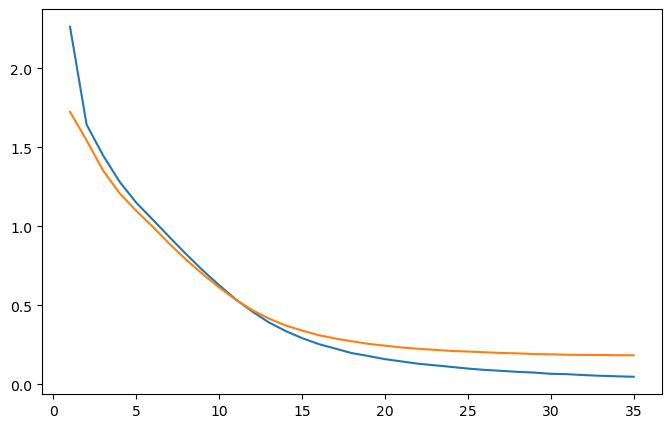

In [30]:
plt.figure(figsize = (8,5))
plt.plot(np.array(model_1.history.epoch)+1, model_1.history.history['loss'])
plt.plot(np.array(model_1.history.epoch)+1, model_1.history.history['val_loss'])
plt.show()

In [31]:
def predict(input_sentence):
    out_text = ''
    seq = tknizer_ita.texts_to_sequences([input_sentence]) 
    pad = pad_sequences(seq, maxlen = 20, dtype='int32', padding='post')
    enc_out, state_h, state_c = model_1.encoder(pad)
    intial = np.zeros((1,1), dtype = 'float32')
    intial[0, 0] = tknizer_eng.word_index['<start>']
    states = [state_h, state_c]
    
    for i in range(20):
        predicted_out, state_h, state_c = model_1.decoder(intial, initial_states = states)
        out = model_1.dense(predicted_out).numpy()
        out = out.reshape(out.shape[-1])
        states = [state_h, state_c] # Update State
        out = np.argmax(out)
        intial = np.zeros((1, 1), dtype = 'float32')
        if tknizer_eng.index_word[out] == '<end>' or i == 20:
            break
        intial[0, 0] = out #Update decoder input
        out_text += tknizer_eng.index_word[out] + ' '
    return out_text

In [32]:
res = pd.DataFrame()
res['Input'] = 0
res['Ground Truth'] = 0
res['Predicted'] = 0
res['Bleu Score'] = 0
m = np.random.randint(0, len(val), 10)
for n in tqdm(m):
    query = val.Italian.values[n]
    pred = predict(query)
    ground = val.English_inp.values[n][8:]
    ground_ = nltk.tokenize.casual.casual_tokenize(ground)
    pred_ = nltk.tokenize.casual.casual_tokenize(pred)
    bleu = nltk.translate.bleu_score.sentence_bleu([ground_], pred_) 
    res = res.append({'Input' : query, 'Ground Truth': ground, 'Predicted' : pred, 'Bleu Score' : bleu},ignore_index= True)
res

100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


,Input,Ground Truth,Predicted,Bleu Score
0,di che colore sono i capelli di tom,what is the color of tom is hair,what color is tom is hair,0.402935
1,mantengo sempre la mia parola,i always keep my word,i always keep my word,1.000000
2,lei divenne cieca,she went blind,she went blind,1.000000
3,odio l inverno,i hate winter,i hate the winter,0.707107
4,tom sapeva che ero arrabbiata,tom knew that i was angry,tom knew that i was mad,0.759836
5,quando diventer grande mi sposer con tom,when i grow up i am going to get married to tom,when i grow up i am going to be a child from tom,0.576084
6,perch mi sta assillando,why are you hounding me,why are you hounding me,1.000000
7,ci posso vivere con quello,i can live with that,can i live with that,0.638943
8,tom non ha mai detto a mary dove ha nascosto i...,tom never told mary where he hid the money he ...,tom never told mary where he hid the money he ...,1.000000
9,siete cos immaturi,you are so immature,you are so immature,1.000000


In [33]:
model_1_bleu_score = np.mean(res['Bleu Score'].values)
print('Average Bleu Score: ', model_1_bleu_score)

Average Bleu Score:  0.8084905157973244
